# Mutation analysis, Database lookup - COSMIC, GDC, TCGA Germline, MSK-IMPACT

In [1]:
import pandas as pd
from tqdm import tqdm
import re
from matplotlib import pyplot as plt
from upsetplot import UpSet
tqdm.pandas()

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 10000)        # Set the display width to a large number
pd.set_option('display.max_colwidth', None) # No limit on column width

In [2]:
cosmic_cancer_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37.tsv"
cosmic_mutation_census_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_MutantCensus_Tsv_v100_GRCh37/Cosmic_MutantCensus_v100_GRCh37.tsv"
cosmic_cell_line_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh38/CellLinesProject_GenomeScreensMutant_Tsv_v100_GRCh38/CellLinesProject_GenomeScreensMutant_v100_GRCh38.tsv"
cosmic_genome_screen_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_GenomeScreensMutant_Tsv_v100_GRCh37/Cosmic_GenomeScreensMutant_v100_GRCh37.tsv"
cosmic_targeted_screen_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_CompleteTargetedScreensMutant_Tsv_v100_GRCh37/Cosmic_CompleteTargetedScreensMutant_v100_GRCh37.tsv"
cosmic_resistance_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_ResistanceMutations_Tsv_v100_GRCh37/Cosmic_ResistanceMutations_v100_GRCh37.tsv"

gdc_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/GDC/frequent-mutations_with_GRCh37.2024-05-15-3.tsv"
hotspots_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/Hotspots/hotspots_v2.xls"
msk_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/MSK-IMPACT/data_mutations.txt"   #! csv
tcga_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/TCGA/germline.xlsx"
oncokb_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/OncoKB/onkokb_cancerGeneList.tsv"

In [ ]:
# !gget cosmic -gv 37 -cv 100 -o {cosmic_reference_folder} -o {'/'.join(cosmic_cancer_path.split('/')[:-2])} -mc cancer -d
# !gget cosmic -gv 37 -cv 100 -o {cosmic_reference_folder} -o {'/'.join(cosmic_mutation_census_path.split('/')[:-2])} -mc census -d
# !gget cosmic -gv 37 -cv 100 -o {cosmic_reference_folder} -o {'/'.join(cosmic_cell_line_path.split('/')[:-2])} -mc cell_line -d
# !gget cosmic -gv 37 -cv 100 -o {cosmic_reference_folder} -o {'/'.join(cosmic_genome_screen_path.split('/')[:-2])} -mc genome_screen -d
# !gget cosmic -gv 37 -cv 100 -o {cosmic_reference_folder} -o {'/'.join(cosmic_targeted_screen_path.split('/')[:-2])} -mc targeted_screen -d
# !gget cosmic -gv 37 -cv 100 -o {cosmic_reference_folder} -o {'/'.join(cosmic_resistance_path.split('/')[:-2])} -mc resistance -d

# # Visit https://portal.gdc.cancer.gov/analysis_page?app=MutationFrequencyApp --> click "Mutations" tab --> click "TSV" --> delete header rows and save as tsv

# !curl -o {hotspots_path} "https://www.cancerhotspots.org/files/hotspots_v2.xls"

# from scripts.download_msk_data import download_msk_data, convert_to_csv
# # msk_txt_path = msk_path.replace(".csv", ".txt")
# download_msk_data(output_path = msk_path)
# # convert_to_csv(input_file = msk_txt_path)

# !curl -o {tcga_path} "https://www.cell.com/cms/10.1016/j.cell.2018.03.039/attachment/757e1418-7a06-487d-ae32-6fc34c4ede07/mmc2.xlsx"   # from https://www.cell.com/cell/fulltext/S0092-8674(18)30363-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418303635%3Fshowall%3Dtrue#supplementaryMaterial

# # Visit https://www.oncokb.org/cancer-genes --> click "Cancer Gene List"

In [3]:
cosmic_cancer_df = pd.read_csv(cosmic_cancer_path, sep='\t')
cosmic_mutation_census_df = pd.read_csv(cosmic_mutation_census_path, sep='\t')
cosmic_cell_line_df = pd.read_csv(cosmic_cell_line_path, sep='\t')
# cosmic_genome_screen_df = pd.read_csv(cosmic_genome_screen_path, sep='\t')
cosmic_targeted_screen_df = pd.read_csv(cosmic_targeted_screen_path, sep='\t')
cosmic_resistance_df = pd.read_csv(cosmic_resistance_path, sep='\t')

gdc_df = pd.read_csv(gdc_path, sep='\t')
hotspots_df = pd.read_excel(hotspots_path)
msk_df = pd.read_csv(msk_path, sep='\t')  # if using csv then remove sep='\t'
tcga_df = pd.read_excel(tcga_path)
oncokb_df = pd.read_csv(oncokb_path, sep='\t')

/tmp/ipykernel_171528/2846861508.py:1: DtypeWarning: Columns (2,56) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_cancer_df = pd.read_csv(cosmic_cancer_path, sep='\t')
/tmp/ipykernel_171528/2846861508.py:2: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_mutation_census_df = pd.read_csv(cosmic_mutation_census_path, sep='\t')
/tmp/ipykernel_171528/2846861508.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_cell_line_df = pd.read_csv(cosmic_cell_line_path, sep='\t')
/tmp/ipykernel_171528/2846861508.py:5: DtypeWarning: Columns (4,6,7,9,10,11,12,13,14,17,19,20,21,22,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_targeted_screen_df = pd.read_csv(cosmic_targeted_screen_path, sep='\t')


In [4]:
cosmic_cancer_df.head()

,GENE_NAME,ACCESSION_NUMBER,ONC_TSG,CGC_TIER,MUTATION_URL,LEGACY_MUTATION_ID,Mutation CDS,Mutation AA,AA_MUT_START,AA_MUT_STOP,SHARED_AA,GENOMIC_WT_ALLELE_SEQ,GENOMIC_MUT_ALLELE_SEQ,AA_WT_ALLELE_SEQ,AA_MUT_ALLELE_SEQ,Mutation Description CDS,Mutation Description AA,ONTOLOGY_MUTATION_CODE,GENOMIC_MUTATION_ID,Mutation genome position GRCh37,Mutation genome position GRCh38,COSMIC_SAMPLE_TESTED,COSMIC_SAMPLE_MUTATED,DISEASE,WGS_DISEASE,EXAC_AF,EXAC_AFR_AF,EXAC_AMR_AF,EXAC_ADJ_AF,EXAC_EAS_AF,EXAC_FIN_AF,EXAC_NFE_AF,EXAC_SAS_AF,GNOMAD_EXOMES_AF,GNOMAD_EXOMES_AFR_AF,GNOMAD_EXOMES_AMR_AF,GNOMAD_EXOMES_ASJ_AF,GNOMAD_EXOMES_EAS_AF,GNOMAD_EXOMES_FIN_AF,GNOMAD_EXOMES_NFE_AF,GNOMAD_EXOMES_SAS_AF,GNOMAD_GENOMES_AF,GNOMAD_GENOMES_AFR_AF,GNOMAD_GENOMES_AMI_AF,GNOMAD_GENOMES_AMR_AF,GNOMAD_GENOMES_ASJ_AF,GNOMAD_GENOMES_EAS_AF,GNOMAD_GENOMES_FIN_AF,GNOMAD_GENOMES_MID_AF,GNOMAD_GENOMES_NFE_AF,GNOMAD_GENOMES_SAS_AF,CLINVAR_CLNSIG,CLINVAR_TRAIT,GERP++_RS,MIN_SIFT_SCORE,MIN_SIFT_PRED,DNDS_DISEASE_QVAL_SIG,MUTATION_SIGNIFICANCE_TIER
0,PODN,ENST00000312553.5,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=29593794,COSM4577438,c.1751C>T,p.A584V,584,584,2,C,T,A,V,Substitution,Substitution - Missense,SO:0001583,COSV57014428,1:53546494-53546494,1:53080822-53080822,45922,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000008,0.000062,0.000000,0.0,0.000000,0.0,0.000009,0.0,0.000039,0.000048,0.0,0.000065,0.0,0.0000,0.0,0.0,0.000044,0.0,NaN,NaN,3.47,0.292,T,NaN,Other
1,PODN,ENST00000312553.5,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=29591814,COSM4397856,c.1496G>A,p.R499Q,499,499,1,G,A,R,Q,Substitution,Substitution - Missense,SO:0001583,COSV57013127,1:53544534-53544534,1:53078862-53078862,45922,6,NaN,NaN,0.000033,0.0004,0.000000,0.000036,0.0,0.0,0.0,0.0,0.000024,0.000200,0.000000,0.0,0.000055,0.0,0.000009,0.0,0.000039,0.000072,0.0,0.000000,0.0,0.0002,0.0,0.0,0.000029,0.0,NaN,NaN,2.75,0.109,T,NaN,Other
2,PODN,ENST00000312553.5,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=29600038,COSM9234519,c.934C>A,p.L312M,312,312,2,C,A,L,M,Substitution,Substitution - Missense,SO:0001583,COSV104396799,1:53543408-53543408,1:53077736-53077736,45922,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.94,0.003,D,NaN,Other
3,PODN,ENST00000312553.5,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=29592187,COSM6063694,c.1423C>T,p.R475C,475,475,2,C,T,R,C,Substitution,Substitution - Missense,SO:0001583,COSV57016857,1:53544461-53544461,1:53078789-53078789,45922,2,NaN,NaN,0.000025,0.0002,0.000087,0.000025,0.0,0.0,0.0,0.0,0.000024,0.000200,0.000029,0.0,0.000000,0.0,0.000018,0.0,0.000007,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.0,0.000015,0.0,NaN,NaN,4.81,0.027,D,NaN,Other
4,PODN,ENST00000312553.5,NaN,NaN,https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=29596066,COSM4390121,c.1282C>A,p.R428S,428,428,3,C,A,R,S,Substitution,Substitution - Missense,SO:0001583,COSV57012790,1:53544320-53544320,1:53078648-53078648,45922,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.81,0.012,D,NaN,Other


In [5]:
cosmic_mutation_census_df.head()

,GENE_SYMBOL,COSMIC_GENE_ID,TRANSCRIPT_ACCESSION,COSMIC_SAMPLE_ID,SAMPLE_NAME,COSMIC_PHENOTYPE_ID,GENOMIC_MUTATION_ID,LEGACY_MUTATION_ID,MUTATION_ID,MUTATION_CDS,MUTATION_AA,MUTATION_DESCRIPTION,MUTATION_ZYGOSITY,LOH,CHROMOSOME,GENOME_START,GENOME_STOP,STRAND,PUBMED_PMID,COSMIC_STUDY_ID,HGVSP,HGVSC,HGVSG,GENOMIC_WT_ALLELE,GENOMIC_MUT_ALLELE,MUTATION_SOMATIC_STATUS
0,KNSTRN,COSG49881,ENST00000249776.8,COSS2637739,METMCC_627,COSO58566047,COSV51104185,COSM6442436,20731161,c.61G>A,p.E21K,missense_variant,NaN,NaN,15,40675097.0,40675097.0,+,26238782.0,NaN,ENSP00000249776.8:p.Glu21Lys,ENST00000249776.8:c.61G>A,15:g.40675097G>A,G,A,Confirmed somatic variant
1,KNSTRN,COSG49881,ENST00000249776.8,COSS2748159,187,COSO36004862,COSV99992166,COSN30738589,20731320,c.304+67C>T,p.?,intron_variant,NaN,NaN,15,40675590.0,40675590.0,+,NaN,COSU683,NaN,ENST00000249776.8:c.304+67C>T,15:g.40675590C>T,C,T,Confirmed somatic variant
2,KNSTRN,COSG49881,ENST00000249776.8,COSS1918829,RK036_C01,COSO29824862,COSV51103374,COSN1675729,20731322,c.486-832G>A,p.?,intron_variant,het,NaN,15,40680875.0,40680875.0,+,NaN,COSU322,NaN,ENST00000249776.8:c.486-832G>A,15:g.40680875G>A,G,A,Variant of unknown origin
3,KNSTRN,COSG49881,ENST00000249776.8,COSS2954383,PD36258a,COSO32686050,COSV107220759,COSN32907718,20730175,c.304+816G>C,p.?,intron_variant,NaN,NaN,15,40676339.0,40676339.0,+,36219477.0,NaN,NaN,ENST00000249776.8:c.304+816G>C,15:g.40676339G>C,G,C,Variant of unknown origin
4,KNSTRN,COSG49881,ENST00000249776.8,COSS2955339,P169_Recurrence1_A,COSO28245232,COSV107220766,COSM10537022,20731325,c.29A>G,p.D10G,missense_variant,NaN,NaN,15,40675065.0,40675065.0,+,28916733.0,NaN,ENSP00000249776.8:p.Asp10Gly,ENST00000249776.8:c.29A>G,15:g.40675065A>G,A,G,Confirmed somatic variant


In [6]:
gdc_df.head()

,ssm_id,dna_change,protein_change,type,consequence,num_cohort_ssm_affected_cases,num_cohort_ssm_cases,cohort_ssm_affected_cases_percentage,num_gdc_ssm_affected_cases,num_gdc_ssm_cases,gdc_ssm_affected_cases_percentage,vep_impact,sift_impact,sift_score,polyphen_impact,polyphen_score,GRCh38_CHROMOSOME,GRCh38_GENOME_START,GRCh38_GENOME_END,liftover_format,GRCH37_liftover,GRCh37_chromosome,GRCh37_GENOME_START,GRCh37_GENOME_END
0,84aef48f-31e6-52e4-8e05-7d5b9ab15087,chr7:g.140753336A>T,BRAF V640E,Substitution,Missense,621,16477,3.77,621,16477,3.77,MODERATE,deleterious,0.00,probably_damaging,0.955,7,140753336,140753336,chr7:140753336-140753336,chr7:140453136-140453136,7,140453136,140453136
1,edd1ae2c-3ca9-52bd-a124-b09ed304fcc2,chr12:g.25245350C>T,KRAS G12D,Substitution,Missense,439,16477,2.66,439,16477,2.66,MODERATE,deleterious,0.00,benign,0.303,12,25245350,25245350,chr12:25245350-25245350,chr12:25398284-25398284,12,25398284,25398284
2,fa9713e8-ce92-5413-aacc-ed3d95ab7906,chr2:g.208248388C>T,IDH1 R132H,Substitution,Missense,399,16477,2.42,399,16477,2.42,MODERATE,deleterious_low_confidence,0.01,benign,0.047,2,208248388,208248388,chr2:208248388-208248388,chr2:209113112-209113112,2,209113112,209113112
3,a34dbc69-77ad-5c45-9c4b-e26ea62bde83,chr3:g.179218303G>A,PIK3CA E545K,Substitution,Missense,313,16477,1.90,313,16477,1.90,MODERATE,deleterious,0.02,probably_damaging,0.909,3,179218303,179218303,chr3:179218303-179218303,chr3:178936091-178936091,3,178936091,178936091
4,4fb37566-16d1-5697-9732-27c359828bc7,chr12:g.25245350C>A,KRAS G12V,Substitution,Missense,301,16477,1.83,301,16477,1.83,MODERATE,deleterious,0.00,probably_damaging,0.972,12,25245350,25245350,chr12:25245350-25245350,chr12:25398284-25398284,12,25398284,25398284


In [7]:
hotspots_df.head()

,Hugo_Symbol,Amino_Acid_Position,log10_pvalue,Mutation_Count,Reference_Amino_Acid,Total_Mutations_in_Gene,Median_Allele_Freq_Rank,Allele_Freq_Rank,Variant_Amino_Acid,Codon_Change,Genomic_Position,Detailed_Cancer_Types,Organ_Types,Tri-nucleotides,Mutability,mu_protein,Total_Samples,Analysis_Type,qvalue,tm,qvalue_pancan,Is_repeat,seq,length,align100,pad12entropy,pad24entropy,pad36entropy,TP,reason,n_MSK,n_Retro,judgement,inNBT,inOncokb,ref,qvaluect,ct,Samples
0,NRAS,61,-1237.691435,422,Q:422,620,0.333333,295|0.692307692307692:0.733333333333333:0.2:0.933333333333333:1:0.25:0.666666666666667:1:0.25:0.571428571428571:1:1:0.5:0.363636363636364:0.428571428571429:0.0833333333333333:1:1:1:1:0.5:1:0.125:0.363636363636364:0.173913043478261:0.25:1:0.8:0.153846153846154:0.857142857142857:0.5:0.5:0.5:1:0.272727272727273:0.214285714285714:1:0.5:1:1:0.2:0.333333333333333:0.6875:0.708333333333333:0.25:0.266666666666667:0.111111111111111:1:1:0.333333333333333:0.428571428571429:0.666666666666667:0.25:0.5:0.833333333333333:0.5:0.735294117647059:0.0476190476190476:0.1:0.133333333333333:0.230769230769231:0.25:1:0.5:0.294117647058824:0.217391304347826:0.46875:0.5:1:0.2:0.166666666666667:0.666666666666667:1:0.8:0.407407407407407:1:0.0212765957446809:0.285714285714286:0.0909090909090909:0.333333333333333:0.2:0.333333333333333:0.5:0.5:1:0.111111111111111:0.5:0.903846153846154:0.5:0.2:1:1:0.0909090909090909:0.4:0.428571428571429:0.0625:0.25:0.833333333333333:1:0.956521739130435:0.111111111111111:0.6:0.212765957446809:0.5:0.207547169811321:1:0.75:0.294117647058824:0.666666666666667:1:0.333333333333333:0.714285714285714:0.142857142857143:1:0.3:0.416666666666667:0.272727272727273:0.25:0.333333333333333:0.345454545454545:0.0952380952380952:0.166666666666667:0.111111111111111:0.454545454545455:0.0666666666666667:1:0.636363636363636:0.636363636363636:0.25:0.272727272727273:0.824324324324324:1:0.75:0.545454545454545:1:1:0.0769230769230769:0.363636363636364:0.290322580645161:0.333333333333333:0.179487179487179:1:0.0666666666666667:0.333333333333333:1:0.478260869565217:0.166666666666667:1:1:0.0276497695852535:0.0716845878136201:0.0263736263736264:0.933333333333333:1:0.5:1:1:0.8125:0.361788617886179:0.113761467889908:0.113761467889908:0.157894736842105:0.333333333333333:0.0555555555555556:0.0357142857142857:0.375:0.111111111111111:0.584415584415584:0.0350877192982456:0.751111111111111:0.761245674740484:0.164989939637827:0.196652719665272:0.135549872122762:0.172113289760349:0.0240963855421687:0.0620767494356659:0.142268041237113:0.147441457068517:0.147959183673469:0.038961038961039:0.686274509803922:0.0929054054054054:0.364787111622555:0.331306990881459:0.691449814126394:0.691449814126394:0.0769230769230769:0.347826086956522:0.117647058823529:0.148148148148148:0.05:0.290030211480363:0.680272108843537:0.188679245283019:0.0701754385964912:0.801526717557252:0.236842105263158:0.1953125:0.0539906103286385:0.015625:0.0390492359932088:0.00790513833992095:0.0597826086956522:0.136783733826248:0.362359550561798:0.0713719270420301:0.328621908127208:0.0657672849915683:0.320099255583127:0.075:0.433021806853583:0.524818401937046:0.524818401937046:0.259259259259259:0.483695652173913:0.0269360269360269:0.100486223662885:0.785507246376812:0.137870855148342:0.472340425531915:0.194331983805668:0.0830769230769231:0.418055555555556:0.546296296296296:0.247596153846154:0.52:0.39832285115304:0.601866251944012:0.234016887816647:0.214007782101167:0.153153153153153:0.137180700094607:0.0666666666666667:0.037037037037037:0.1:0.2:0.458333333333333:0.0588235294117647:0.111111111111111:0.333333333333333:0.181818181818182:0.473684210526316:0.5:0.2:0.136363636363636:0.0769230769230769:0.142857142857143:0.285714285714286:0.25:0.445714285714286:0.149377593360996:0.0227790432801822:0.182278481012658:0.540123456790123:0.021505376344086:0.541666666666667:0.00429184549356223:0.473684210526316:0.103508771929825:0.0930232558139535:0.391304347826087:0.072:0.0113636363636364:0.148837209302326:0.448051948051

In [8]:
msk_df.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,dbSNP_Val_Status,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Match_Norm_Seq_Allele1,Match_Norm_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,Match_Norm_Validation_Allele1,Match_Norm_Validation_Allele2,Verification_Status,Validation_Status,Mutation_Status,Sequencing_Phase,Sequence_Source,Validation_Method,Score,BAM_File,Sequencer,t_ref_count,t_alt_count,n_ref_count,n_alt_count,HGVSc,HGVSp,HGVSp_Short,Transcript_ID,RefSeq,Protein_position,Codons,Hotspot,cDNA_change
0,SPEN,NaN,NaN,GRCh37,1,16265908,16265908,+,missense_variant,Missense_Mutation,SNP,A,A,T,NaN,NaN,P-0000004-T01-IM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400,73,NaN,NaN,ENST00000375759.3:c.10981A>T,p.Ile3661Phe,p.I3661F,ENST00000375759,NM_015001.2,3661.0,Att/Ttt,0,c.10981A>T
1,ALK,NaN,NaN,GRCh37,2,29543736,29543736,+,missense_variant,Missense_Mutation,SNP,A,A,G,NaN,NaN,P-0000004-T01-IM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,13,NaN,NaN,ENST00000389048.3:c.1427T>C,p.Val476Ala,p.V476A,ENST00000389048,NM_004304.4,476.0,gTg/gCg,0,c.1427T>C
2,PDCD1,NaN,NaN,GRCh37,2,242793433,242793433,+,missense_variant,Missense_Mutation,SNP,G,G,A,NaN,NaN,P-0000004-T01-IM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225,15,NaN,NaN,ENST00000334409.5:c.644C>T,p.Ala215Val,p.A215V,ENST00000334409,NM_005018.2,215.0,gCc/gTc,0,c.644C>T
3,MAP3K1,NaN,NaN,GRCh37,5,56177843,56177843,+,missense_variant,Missense_Mutation,SNP,C,C,G,NaN,NaN,P-0000004-T01-IM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370,12,NaN,NaN,ENST00000399503.3:c.2816C>G,p.Ser939Cys,p.S939C,ENST00000399503,NM_005921.1,939.0,tCt/tGt,0,c.2816C>G
4,FLT4,NaN,NaN,GRCh37,5,180030313,180030313,+,missense_variant,Missense_Mutation,SNP,C,C,A,NaN,NaN,P-0000004-T01-IM3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,25,NaN,NaN,ENST00000261937.6:c.3971G>T,p.Arg1324Leu,p.R1324L,ENST00000261937,NM_182925.4,1324.0,cGg/cTg,0,c.3971G>T


In [57]:
tcga_df.head()

,HUGO_Symbol,cancer,Start,transcript_name,HGVSg,Genotype,Chromosome,Stop,Reference,Alternate,Variant_Classification,HGVSc,HGVSp,Allele_Frequency,VEP_Most_Severe_Consequence,Positive_Evidence,Negative_Evidence,Positive_CharGer_Score,Negative_CharGer_Score,CharGer_Score,ClinVar_Pathogenicity,ACMG_Classification,CharGer_Classification,PubMed_Link,ClinVar_Traits,CharGer_Summary,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,EXON,INTRON,HGVSc.1,HGVSp.1,cDNA_position,CDS_position,Protein_position,Amino_acids,Codons,Existing_variation,DISTANCE,STRAND,FLAGS,VARIANT_CLASS,SYMBOL_SOURCE,HGNC_ID,CANONICAL,TSL,APPRIS,CCDS,ENSP,SWISSPROT,TREMBL,UNIPARC,GENE_PHENO,SIFT,PolyPhen,DOMAINS,HGVS_OFFSET,GMAF,AFR_MAF,AMR_MAF,EAS_MAF,EUR_MAF,SAS_MAF,AA_MAF,EA_MAF,ExAC_MAF,ExAC_Adj_MAF,ExAC_AFR_MAF,ExAC_AMR_MAF,ExAC_EAS_MAF,ExAC_FIN_MAF,ExAC_NFE_MAF,ExAC_OTH_MAF,ExAC_SAS_MAF,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE..,ExAC_adj_AF,normalDepth,normalRefCnt,normalAltCnt,tumorDepth,tumorRefCnt,tumorAltCnt,normalVAF,tumorVAF,predisposition_gene,cancer_term_trait,cancer_related,Cohort_AC,Cohort_AF,ExAC_adj_AF_Manual,previous_manual_review,reyka_manual_review,HGVSp_short,Overall_Classification,ExAC_assoc_Var,ExAC_assoc_ExAC_AN,ExAC_assoc_ExAC_AC,ExAC_assoc_ExAC_nonTCGA_AN,ExAC_assoc_ExAC_nonTCGA_AC,ExAC_assoc_TCGA_AN,ExAC_assoc_TCGA_AC,ExAC_assoc_OR,ExAC_assoc_P,log2RSEM,expressionQuantile,transcript.length,LOH_AI_event_type,LOH_PERMUT_PVAL,LOH_FISHER_PVAL,LOH_COMBINED_PVAL,LOH_FDR,binary_type,TumorByNormalVAF,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,birth_days_to,vital_status,tumor_status,last_contact_days_to,death_days_to,cause_of_death,new_tumor_event_type,new_tumor_event_site,new_tumor_event_site_other,new_tumor_event_dx_days_to,treatment_outcome_first_course,margin_status,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,PFI.1,PFI.time.1,PFI.2,PFI.time.2,Redaction,AIM_ethnicity,PCGP,Somatic_Variant_Classification,Somatic_HGVSp,colocalized_somatic_mutation_count,normal_type,LOH_Sig,Allele_Frequency_Plot,Gene_Classification,CNV_value,CNV_thres,AS_LOH,HGVSG_JR
0,APC,BRCA,112128228,ENST00000457016,5:g.112128228_112128228delT,"0/1:90,77:167:99:2353,0,2847",5,112128228,Q,X,splice_donor_variant,ENST00000457016:c.delT,ENSP00000413133:p.,0,splice_donor_variant,"PM2,PVS1",NaN,10,0,10,NaN,Uncertain Significance,Pathogenic,NaN,NaN,PVS1(splice_donor_variant in susceptible gene APC) -- PM2(Low/absent allele frequency None<=0.0005),-,splice_donor_variant,HIGH,APC,ENSG00000134982,Transcript,ENST00000257430,protein_coding,NaN,2018-07-15 00:00:00,ENST00000257430.4:c.729+2delN,NaN,NaN,NaN,NaN,NaN,NaN,rs780245766,NaN,1,NaN,deletion,HGNC,583,NaN,NaN,NaN,CCDS4107.1,ENSP00000257430,P25054,Q9UM98&Q9P119&Q9HAW6&Q4LE70&E9PFT7&D6RFL6&B2ZRE1&A5HB97&A5HB96&A5HB95&A5HB94&A1YIQ7,UPI000013CF60,1.0,NaN,NaN,NaN,NaN,NaN,-:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-:0,-:8.237e-06,-:9.707e-05,-:8.325e-06,-:0,-:0,-:0,-:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,168,90,78,184.0,72.0,112.0,0.464286,0.608696,True,False,True,1,0.000096,NaN,Pass,pass,NaN,Likely Pathogenic,5:112128227:.:GT:G,120126.0,1.0,104924.0,0.0,15202.0,1.0,inf,0.126558,8.799404,0.138434,8529.0,TEST_EVENT,0.318184,0.004513,0.010835,0.122155,Truncation,1.311037,42.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,[Not Applicable],Infiltrating Ductal Carcinoma,[Not Available],1995.0,Indeterminate (neither Pre or Postmenopausal),-15625.0,Alive,TUMOR FREE,7106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,afr,False,NaN,NaN,0,0,Suggestive,0.009554,TSG,-0.260,-1.0,Copy Number Deletion of WT Allele,5:112128228-112128228;Q>X
1,APC,READ,112102093,ENST00000457016,5:g.112102093T>A,"0/1:99,99:198:99:2309,0,2371",5,112102093,T,A,stop_gained,ENST00000457016:c.586T>A,ENSP00000413133:p.L69*,0,stop_gained,"PM2,PVS1

In [11]:
oncokb_df.head()

,Hugo Symbol,Entrez Gene ID,GRCh37 Isoform,GRCh37 RefSeq,GRCh38 Isoform,GRCh38 RefSeq,Is Oncogene,Is Tumor Suppressor Gene,# of occurrence within resources (Column J-P),OncoKB Annotated,MSK-IMPACT,MSK-HEME,FOUNDATION ONE,FOUNDATION ONE HEME,Vogelstein,COSMIC CGC (v99),Gene Aliases
0,ABL1,25,ENST00000318560,NM_005157.4,ENST00000318560,NM_005157.4,Yes,No,7,Yes,Yes,Yes,Yes,Yes,Yes,Yes,"ABL, JTK7, c-ABL"
1,AKT1,207,ENST00000349310,NM_001014431.1,ENST00000349310,NM_001014431.1,Yes,No,7,Yes,Yes,Yes,Yes,Yes,Yes,Yes,"AKT, PKB, PRKBA, RAC, RAC-alpha"
2,ALK,238,ENST00000389048,NM_004304.4,ENST00000389048,NM_004304.4,Yes,No,7,Yes,Yes,Yes,Yes,Yes,Yes,Yes,CD246
3,AMER1,139285,ENST00000330258,NM_152424.3,ENST00000374869,NM_152424.3,No,Yes,7,Yes,Yes,Yes,Yes,Yes,Yes,Yes,"FAM123B, FLJ39827, RP11-403E24.2, WTX"
4,APC,324,ENST00000257430,NM_000038.5,ENST00000257430,NM_000038.5,No,Yes,7,Yes,Yes,Yes,Yes,Yes,Yes,Yes,"DP2.5, PPP1R46"


In [12]:
cosmic_classification_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_Classification_Tsv_v100_GRCh37/Cosmic_Classification_v100_GRCh37.tsv"
cosmic_gene_census_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_CancerGeneCensus_Tsv_v100_GRCh37/Cosmic_CancerGeneCensus_v100_GRCh37.tsv"
cosmic_hallmark_path = "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/Cosmic_CancerGeneCensusHallmarksOfCancer_Tsv_v100_GRCh37/Cosmic_CancerGeneCensusHallmarksOfCancer_v100_GRCh37.tsv"

cosmic_classification_df = pd.read_csv(cosmic_classification_path, sep='\t')
cosmic_gene_census_df = pd.read_csv(cosmic_gene_census_path, sep='\t')
cosmic_hallmark_df = pd.read_csv(cosmic_hallmark_path, sep='\t')

In [13]:
cosmic_hallmark_df = cosmic_hallmark_df.astype(str)
cosmic_hallmark_df = cosmic_hallmark_df.rename(columns=lambda x: x if x in ['GENE_SYMBOL', 'COSMIC_GENE_ID'] else f"{x}_cosmic_hallmark")

cosmic_hallmark_df_combined = cosmic_hallmark_df.groupby(['GENE_SYMBOL', 'COSMIC_GENE_ID']).agg({
    'CELL_TYPE_cosmic_hallmark': '; '.join,
    'PUBMED_PMID_cosmic_hallmark': '; '.join,
    'HALLMARK_cosmic_hallmark': '; '.join,
    'IMPACT_cosmic_hallmark': '; '.join,
    'DESCRIPTION_cosmic_hallmark': '; '.join,
    'CELL_LINE_cosmic_hallmark': '; '.join
}).reset_index()

cosmic_hallmark_df_combined['is_hallmark_gene'] = True

# merge hallmark into census by COSMIC_GENE_ID
cosmic_gene_census_df = cosmic_gene_census_df.astype(str)
cosmic_gene_census_df = cosmic_gene_census_df.rename(columns=lambda x: x if x in ['GENE_SYMBOL', 'COSMIC_GENE_ID'] else f"{x}_cosmic_gene_census")
cosmic_gene_census_df_combined = cosmic_gene_census_df.merge(cosmic_hallmark_df_combined, on=['GENE_SYMBOL', 'COSMIC_GENE_ID'], how='outer')
cosmic_gene_census_df_combined['is_cosmic_hallmark_gene'] = cosmic_gene_census_df_combined['is_hallmark_gene'].fillna(False)
cosmic_gene_census_df_combined['is_cosmic_cancer_gene_census_gene'] = True

In [14]:
cosmic_cancer_df = cosmic_cancer_df.merge(cosmic_gene_census_df_combined, left_on='GENE_NAME', right_on='GENE_SYMBOL', how='left')
cosmic_mutation_census_df = cosmic_mutation_census_df.merge(cosmic_gene_census_df_combined, on=['GENE_SYMBOL', 'COSMIC_GENE_ID'], how='left')
cosmic_cell_line_df = cosmic_cell_line_df.merge(cosmic_gene_census_df_combined, on=['GENE_SYMBOL', 'COSMIC_GENE_ID'], how='left')
# cosmic_genome_screen_df = cosmic_genome_screen_df.merge(cosmic_gene_census_df_combined, on='GENE_SYMBOL', how='left')
cosmic_targeted_screen_df = cosmic_targeted_screen_df.merge(cosmic_gene_census_df_combined, on=['GENE_SYMBOL', 'COSMIC_GENE_ID'], how='left')
cosmic_resistance_df = cosmic_resistance_df.merge(cosmic_gene_census_df_combined, on=['GENE_SYMBOL', 'COSMIC_GENE_ID'], how='left')

cosmic_cancer_df['is_cosmic_cancer_gene_census_gene'] = cosmic_cancer_df['is_cosmic_cancer_gene_census_gene'].fillna(False)
cosmic_mutation_census_df['is_cosmic_cancer_gene_census_gene'] = cosmic_mutation_census_df['is_cosmic_cancer_gene_census_gene'].fillna(False)
cosmic_cell_line_df['is_cosmic_cancer_gene_census_gene'] = cosmic_cell_line_df['is_cosmic_cancer_gene_census_gene'].fillna(False)
# cosmic_genome_screen_df['is_cosmic_cancer_gene_census_gene'] = cosmic_genome_screen_df['is_cosmic_cancer_gene_census_gene'].fillna(False)
cosmic_targeted_screen_df['is_cosmic_cancer_gene_census_gene'] = cosmic_targeted_screen_df['is_cosmic_cancer_gene_census_gene'].fillna(False)
cosmic_resistance_df['is_cosmic_cancer_gene_census_gene'] = cosmic_resistance_df['is_cosmic_cancer_gene_census_gene'].fillna(False)

In [15]:
# cosmic_classification_df = cosmic_classification_df.astype(str)
cosmic_classification_df = cosmic_classification_df.rename(columns=lambda x: x if x in ['COSMIC_PHENOTYPE_ID'] else f"{x}_cosmic_classification")

cosmic_mutation_census_df = cosmic_mutation_census_df.merge(cosmic_classification_df, on='COSMIC_PHENOTYPE_ID', how='left')
cosmic_cell_line_df = cosmic_cell_line_df.merge(cosmic_classification_df, on='COSMIC_PHENOTYPE_ID', how='left')
# cosmic_genome_screen_df = cosmic_genome_screen_df.merge(cosmic_classification_df, on='COSMIC_PHENOTYPE_ID', how='left')
cosmic_targeted_screen_df = cosmic_targeted_screen_df.merge(cosmic_classification_df, on='COSMIC_PHENOTYPE_ID', how='left')
cosmic_resistance_df = cosmic_resistance_df.merge(cosmic_classification_df, on='COSMIC_PHENOTYPE_ID', how='left')

In [16]:
def gdc_preprocessing(gdc_df):
    # # Function to extract chromosome number
    # def extract_chromosome(dna_change):
    #     return re.search(r'^chr(\w+):', dna_change).group(1)

    # # Function to extract start position
    # def extract_start_position(dna_change):
    #     return int(re.search(r'g\.(\d+)', dna_change).group(1))

    # # Function to extract end position
    # def extract_end_position(row):
    #     dna_change = row['dna_change']
    #     start_position = row['GENOME_START']
    #     if '>' in dna_change:  # Substitution
    #         return start_position
    #     elif 'ins' in dna_change:  # Insertion or complex mutation
    #         return int(re.search(r'_(\d+)', dna_change).group(1))
    #     elif 'del' in dna_change:  # Deletion
    #         del_match = re.search(r'del([A-Z]+)', dna_change)
    #         if del_match:
    #             length = len(del_match.group(1))
    #             return start_position + length - 1
    #         else:  # Complex deletion-insertion
    #             return int(re.search(r'_(\d+)', dna_change).group(1))
    #     return start_position

    # Function to extract start nucleotide
    def extract_start_nucleotide(dna_change):
        if '>' in dna_change:  # Substitution
            return re.search(r'(\w+)>', dna_change).group(1)[-1]
        elif 'del' in dna_change:  # Deletion and Delins
            return 'Q'
        return 'X'  # Default for insertions and others


    def extract_end_nucleotide(dna_change):
        if '>' in dna_change:  # Substitution
            return re.search(r'>(\w+)', dna_change).group(1)
        elif 'ins' in dna_change:  # Insertion
            return re.search(r'ins(\w+)', dna_change).group(1)
        elif 'del' in dna_change:  # Deletion
            return 'X'
        return 'Q'  # Default for other cases

    # Apply the functions to create new columns
    # gdc_df['CHROMOSOME'] = gdc_df['dna_change'].apply(extract_chromosome)
    # gdc_df['GENOME_START'] = gdc_df['dna_change'].apply(extract_start_position)
    # gdc_df['GENOME_END'] = gdc_df.apply(extract_end_position, axis=1)
    gdc_df['GENOMIC_WT_ALLELE'] = gdc_df['dna_change'].apply(extract_start_nucleotide)
    gdc_df['GENOMIC_MUT_ALLELE'] = gdc_df['dna_change'].apply(extract_end_nucleotide)

    return gdc_df

In [17]:
# Regular expression patterns
substitution_pattern = re.compile(r'c\.\d+[A-Z]>([A-Z])')
nonsubstitution_pattern = re.compile(r'c\.\d+_?\d*[a-z]*[A-Z]+')

# Function to extract components based on presence of '>'
def extract_msk_alleles(cdna_change):
    GENOMIC_WT_ALLELE = "error"
    GENOMIC_MUT_ALLELE = "error"

    try:
        match_with_sub = substitution_pattern.match(cdna_change)
        if match_with_sub:
            GENOMIC_WT_ALLELE = cdna_change[cdna_change.index('>') - 1]
            GENOMIC_MUT_ALLELE = cdna_change[cdna_change.index('>') + 1:]
        else:
            match_without_sub = nonsubstitution_pattern.match(cdna_change)
            if match_without_sub:
                mutation_type = ''.join(re.findall(r'[a-z]+', cdna_change))[1:]
                if mutation_type == 'del':
                    GENOMIC_WT_ALLELE = 'Q'
                    GENOMIC_MUT_ALLELE = 'X'
                elif mutation_type == 'ins' or mutation_type == 'dup':
                    GENOMIC_WT_ALLELE = 'X'
                    GENOMIC_MUT_ALLELE = ''.join(re.findall(r'[A-Z]+', cdna_change))
                elif mutation_type == 'delin' or mutation_type == 'delins':
                    GENOMIC_WT_ALLELE = 'Q'
                    GENOMIC_MUT_ALLELE = ''.join(re.findall(r'[A-Z]+', cdna_change))
    except Exception as e:
        pass

    return GENOMIC_WT_ALLELE, GENOMIC_MUT_ALLELE

In [18]:
# Compile the regular expressions once

substitution_pattern_cosmic = re.compile(r'.*([A-Z])>([A-Z])')
nonsubstitution_pattern_cosmic = re.compile(r'.*[0-9+\-*?\\)](ins|delins|dup|inv|del)([A-Z]*)')

def extract_cosmic_alleles_vectorized(cdna_changes):
    GENOMIC_WT_ALLELE_jr = []
    GENOMIC_MUT_ALLELE_jr = []
    mutation_type_jr_list = []

    for cdna_change in cdna_changes:
        wt_allele = "error"
        mut_allele = "error"
        mutation_type_jr = "error"
        
        match_with_sub = substitution_pattern_cosmic.match(cdna_change)
        if match_with_sub:
            wt_allele = match_with_sub.group(1)
            mut_allele = match_with_sub.group(2)
            mutation_type_jr = 'substitution'
            assert len(wt_allele) == 1 and len(mut_allele) == 1 and re.match(r'^[ATGCN]*$', wt_allele) and re.match(r'^[ATGCN]*$', mut_allele)
        else:
            match_without_sub = nonsubstitution_pattern_cosmic.match(cdna_change)
            if match_without_sub:
                mutation_type = match_without_sub.group(1)
                if mutation_type == 'del':
                    wt_allele = 'Q'
                    mut_allele = 'X'
                    mutation_type_jr = 'deletion'
                elif mutation_type == 'ins':
                    wt_allele = 'X'
                    mut_allele = match_without_sub.group(2)
                    mutation_type_jr = 'insertion'
                    assert re.match(r'^[ATGCN]*$', mut_allele)
                elif mutation_type in {'delin', 'delins'}:
                    wt_allele = 'Q'
                    mut_allele = match_without_sub.group(2)
                    mutation_type_jr = 'delins'
                    assert re.match(r'^[ATGCN]*$', mut_allele)
                elif mutation_type == 'dup':
                    wt_allele = 'X'
                    mut_allele = 'dup'  # Placeholder for now
                    mutation_type_jr = 'duplication'
                elif mutation_type == 'inv':
                    wt_allele = 'inv'  # Placeholder for now
                    mut_allele = 'inv'  # Placeholder for now
                    mutation_type_jr = 'inversion'

        GENOMIC_WT_ALLELE_jr.append(wt_allele)
        GENOMIC_MUT_ALLELE_jr.append(mut_allele)
        mutation_type_jr_list.append(mutation_type_jr)

        if mutation_type_jr == 'error':
            pass

    
    return GENOMIC_WT_ALLELE_jr, GENOMIC_MUT_ALLELE_jr, mutation_type_jr_list

In [19]:
substitution_pattern_cosmic_noncancer = re.compile(r'.*([A-Z])>([A-Z])')
nonsubstitution_pattern_cosmic_noncancer = re.compile(r'.*[0-9+\-*?\\)](ins|delins|dup|inv|del)([A-Z]*)')

def extract_cosmic_noncancer_alleles_vectorized(cdna_changes):
    GENOMIC_WT_ALLELE_jr = []
    GENOMIC_MUT_ALLELE_jr = []
    mutation_type_jr_list = []

    for cdna_change in cdna_changes:
        wt_allele = "error"
        mut_allele = "error"
        mutation_type_jr = "error"

        try:
            match_with_sub = substitution_pattern_cosmic_noncancer.match(cdna_change)
        
            if match_with_sub:
                wt_allele = match_with_sub.group(1)
                mut_allele = match_with_sub.group(2)
                mutation_type_jr = 'substitution'
                assert len(wt_allele) == 1 and len(mut_allele) == 1 and re.match(r'^[ATGCN]*$', wt_allele) and re.match(r'^[ATGCN]*$', mut_allele)
            else:
                match_without_sub = nonsubstitution_pattern_cosmic_noncancer.match(cdna_change)
                if match_without_sub:
                    mutation_type = match_without_sub.group(1)
                    if mutation_type == 'del':
                        wt_allele = 'Q'
                        mut_allele = 'X'
                        mutation_type_jr = 'deletion'
                    elif mutation_type == 'ins':
                        wt_allele = 'X'
                        mut_allele = match_without_sub.group(2)
                        mutation_type_jr = 'insertion'
                        assert re.match(r'^[ATGCN]*$', mut_allele)
                    elif mutation_type in {'delin', 'delins'}:
                        wt_allele = 'Q'
                        mut_allele = match_without_sub.group(2)
                        mutation_type_jr = 'delins'
                        assert re.match(r'^[ATGCN]*$', mut_allele)
                    elif mutation_type == 'dup':
                        wt_allele = 'X'
                        mut_allele = 'dup'  # Placeholder for now
                        mutation_type_jr = 'duplication'
                    elif mutation_type == 'inv':
                        wt_allele = 'inv'  # Placeholder for now
                        mut_allele = 'inv'  # Placeholder for now
                        mutation_type_jr = 'inversion'
                    else:
                        pass
        except Exception as e:
            pass

        GENOMIC_WT_ALLELE_jr.append(wt_allele)
        GENOMIC_MUT_ALLELE_jr.append(mut_allele)
        mutation_type_jr_list.append(mutation_type_jr)

        # if mutation_type_jr == 'error' and '?' not in cdna_change and not '>N' in cdna_change:
        #     pass

    return GENOMIC_WT_ALLELE_jr, GENOMIC_MUT_ALLELE_jr, mutation_type_jr_list

In [21]:
cosmic_cancer_df['GENOMIC_WT_ALLELE_jr'], cosmic_cancer_df['GENOMIC_MUT_ALLELE_jr'], cosmic_cancer_df['mutation_type_jr'] = extract_cosmic_alleles_vectorized(cosmic_cancer_df['Mutation CDS'])
cosmic_mutation_census_df['GENOMIC_WT_ALLELE_jr'], cosmic_mutation_census_df['GENOMIC_MUT_ALLELE_jr'], cosmic_mutation_census_df['mutation_type_jr'] = extract_cosmic_noncancer_alleles_vectorized(cosmic_mutation_census_df['MUTATION_CDS'])
cosmic_cell_line_df['GENOMIC_WT_ALLELE_jr'], cosmic_cell_line_df['GENOMIC_MUT_ALLELE_jr'], cosmic_cell_line_df['mutation_type_jr'] = extract_cosmic_noncancer_alleles_vectorized(cosmic_cell_line_df['MUTATION_CDS'])
# cosmic_genome_screen_df['GENOMIC_WT_ALLELE_jr'], cosmic_genome_screen_df['GENOMIC_MUT_ALLELE_jr'], cosmic_genome_screen_df['mutation_type_jr'] = extract_cosmic_noncancer_alleles_vectorized(cosmic_genome_screen_df['MUTATION_CDS'])
cosmic_targeted_screen_df['GENOMIC_WT_ALLELE_jr'], cosmic_targeted_screen_df['GENOMIC_MUT_ALLELE_jr'], cosmic_targeted_screen_df['mutation_type_jr'] = extract_cosmic_noncancer_alleles_vectorized(cosmic_targeted_screen_df['MUTATION_CDS'])
cosmic_resistance_df['GENOMIC_WT_ALLELE_jr'], cosmic_resistance_df['GENOMIC_MUT_ALLELE_jr'], cosmic_resistance_df['mutation_type_jr'] = extract_cosmic_noncancer_alleles_vectorized(cosmic_resistance_df['MUTATION_CDS'])

# from scripts.gdc_liftover import convert_gdc_to_37
# gdc_df = convert_gdc_to_37(gdc_df, output_path = '/home/jrich/Desktop/CART_prostate_sc/data/reference/GDC/frequent-mutations_with_GRCh37.2024-05-15-3.tsv')
gdc_df['gene_name'] = gdc_df['protein_change'].str.split(' ').str[0]
gdc_df = gdc_preprocessing(gdc_df)
msk_df[['GENOMIC_WT_ALLELE', 'GENOMIC_MUT_ALLELE']] = msk_df['cDNA_change'].progress_apply(lambda x: pd.Series(extract_msk_alleles(x)))
tcga_df['Reference'] = tcga_df['Reference'].str.replace('-', 'X', regex=False)
tcga_df['Alternate'] = tcga_df['Alternate'].str.replace('-', 'X', regex=False)
tcga_df.loc[tcga_df['Alternate'] == 'X', 'Reference'] = 'Q'

100%|██████████| 78263/78263 [00:07<00:00, 10770.21it/s]


In [22]:
print("cosmic cancer variants", cosmic_cancer_df['mutation_type_jr'].unique())
print("cosmic mutation census variants", cosmic_mutation_census_df['mutation_type_jr'].unique())
print("cosmic cell line variants", cosmic_cell_line_df['mutation_type_jr'].unique())
# print("cosmic genome screen variants", cosmic_genome_screen_df['mutation_type_jr'].unique())
print("cosmic targeted screen variants", cosmic_targeted_screen_df['mutation_type_jr'].unique())
print("cosmic resistance variants", cosmic_resistance_df['mutation_type_jr'].unique())

print("gdc variants", gdc_df['type'].unique())
# print("hotspots variants", hotspots_df['Variant_Classification'].unique())
print("MSK variants", msk_df['Variant_Type'].unique())
print("TCGA variants", tcga_df['VARIANT_CLASS'].unique())

cosmic cancer variants ['substitution' 'delins' 'duplication' 'deletion' 'insertion' 'inversion']
cosmic mutation census variants ['substitution' 'deletion' 'delins' 'duplication' 'insertion' 'inversion'
 'error']
cosmic cell line variants ['substitution' 'deletion' 'delins' 'duplication' 'insertion']
cosmic targeted screen variants ['substitution' 'deletion' 'insertion' 'duplication' 'delins' 'error'
 'inversion']
cosmic resistance variants ['substitution' 'error' 'delins' 'duplication' 'deletion' 'inversion'
 'insertion']
gdc variants ['Substitution' 'Deletion' 'Insertion' 'Oligo-nucleotide polymorphism'
 'Tri-nucleotide polymorphism']
MSK variants ['SNP' 'DEL' 'INS' 'DNP' 'ONP' 'TNP']
TCGA variants ['deletion' 'SNV' 'insertion']
icgc variants ['single base substitution' 'deletion of <=200bp'
 'multiple base substitution (>=2bp and <=200bp)']


In [23]:
cosmic_cancer_df = cosmic_cancer_df[~cosmic_cancer_df['mutation_type_jr'].isin(['error'])]
cosmic_mutation_census_df = cosmic_mutation_census_df[~cosmic_mutation_census_df['mutation_type_jr'].isin(['error'])]
cosmic_cell_line_df = cosmic_cell_line_df[~cosmic_cell_line_df['mutation_type_jr'].isin(['error'])]
# cosmic_genome_screen_df = cosmic_genome_screen_df[~cosmic_genome_screen_df['mutation_type_jr'].isin(['error'])]
cosmic_targeted_screen_df = cosmic_targeted_screen_df[~cosmic_targeted_screen_df['mutation_type_jr'].isin(['error'])]
cosmic_resistance_df = cosmic_resistance_df[~cosmic_resistance_df['mutation_type_jr'].isin(['error'])]

In [24]:
cosmic_cancer_df = cosmic_cancer_df.dropna(subset=['Mutation genome position GRCh37', 'GENOMIC_WT_ALLELE_jr', 'GENOMIC_MUT_ALLELE_jr'])
cosmic_mutation_census_df = cosmic_mutation_census_df.dropna(subset=['CHROMOSOME', 'GENOME_START', 'GENOME_STOP', 'GENOMIC_WT_ALLELE_jr', 'GENOMIC_MUT_ALLELE_jr'])  # HGVSG
cosmic_cell_line_df = cosmic_cell_line_df.dropna(subset=['CHROMOSOME', 'GENOME_START', 'GENOME_STOP', 'GENOMIC_WT_ALLELE_jr', 'GENOMIC_MUT_ALLELE_jr'])
# cosmic_genome_screen_df = cosmic_genome_screen_df.dropna(subset=['CHROMOSOME', 'GENOME_START', 'GENOME_END', 'GENOMIC_WT_ALLELE_jr', 'GENOMIC_MUT_ALLELE_jr'])
cosmic_targeted_screen_df = cosmic_targeted_screen_df.dropna(subset=['CHROMOSOME', 'GENOME_START', 'GENOME_STOP', 'GENOMIC_WT_ALLELE_jr', 'GENOMIC_MUT_ALLELE_jr'])
cosmic_resistance_df = cosmic_resistance_df.dropna(subset=['CHROMOSOME', 'GENOME_START', 'GENOME_STOP', 'GENOMIC_WT_ALLELE_jr', 'GENOMIC_MUT_ALLELE_jr'])

gdc_df = gdc_df.dropna(subset=['GRCh37_chromosome', 'GRCh37_GENOME_START', 'GRCh37_GENOME_END', 'GENOMIC_WT_ALLELE', 'GENOMIC_MUT_ALLELE'])
# hotspots_df = hotspots_df.dropna(subset=['Chromosome', 'Start', 'End', 'Reference', 'Variant'])
msk_df = msk_df.dropna(subset=['Chromosome', 'Start_Position', 'End_Position', 'GENOMIC_WT_ALLELE', 'GENOMIC_MUT_ALLELE'])
tcga_df = tcga_df.dropna(subset=['Chromosome', 'Start', 'Stop', 'Reference', 'Alternate'])

In [53]:
# CHROMOSOME:START-END;WT>MUTANT
cosmic_cancer_df['HGVSG_JR'] = cosmic_cancer_df['Mutation genome position GRCh37'] + ';' + cosmic_cancer_df['GENOMIC_WT_ALLELE_jr'] + '>' + cosmic_cancer_df['GENOMIC_MUT_ALLELE_jr']
cosmic_mutation_census_df['HGVSG_JR'] = cosmic_mutation_census_df['CHROMOSOME'].astype(str) + ':' + cosmic_mutation_census_df['GENOME_START'].astype(str) + '-' + cosmic_mutation_census_df['GENOME_STOP'].astype(str) + ';' + cosmic_mutation_census_df['GENOMIC_WT_ALLELE_jr'] + '>' + cosmic_mutation_census_df['GENOMIC_MUT_ALLELE_jr']
cosmic_cell_line_df['HGVSG_JR'] = cosmic_cell_line_df['CHROMOSOME'].astype(str) + ':' + cosmic_cell_line_df['GENOME_START'].astype(str) + '-' + cosmic_cell_line_df['GENOME_STOP'].astype(str) + ';' + cosmic_cell_line_df['GENOMIC_WT_ALLELE_jr'] + '>' + cosmic_cell_line_df['GENOMIC_MUT_ALLELE_jr']
# cosmic_genome_screen_df['HGVSG_JR'] = cosmic_genome_screen_df['CHROMOSOME'].astype(str) + ':' + cosmic_genome_screen_df['GENOME_START'].astype(str) + '-' + cosmic_genome_screen_df['GENOME_END'].astype(str) + ';' + cosmic_genome_screen_df['GENOMIC_WT_ALLELE_jr'] + '>' + cosmic_genome_screen_df['GENOMIC_MUT_ALLELE_jr']
cosmic_targeted_screen_df['HGVSG_JR'] = cosmic_targeted_screen_df['CHROMOSOME'].astype(str) + ':' + cosmic_targeted_screen_df['GENOME_START'].astype(str) + '-' + cosmic_targeted_screen_df['GENOME_STOP'].astype(str) + ';' + cosmic_targeted_screen_df['GENOMIC_WT_ALLELE_jr'] + '>' + cosmic_targeted_screen_df['GENOMIC_MUT_ALLELE_jr']
cosmic_resistance_df['HGVSG_JR'] = cosmic_resistance_df['CHROMOSOME'].astype(str) + ':' + cosmic_resistance_df['GENOME_START'].astype(str) + '-' + cosmic_resistance_df['GENOME_STOP'].astype(str) + ';' + cosmic_resistance_df['GENOMIC_WT_ALLELE_jr'] + '>' + cosmic_resistance_df['GENOMIC_MUT_ALLELE_jr']

gdc_df['HGVSG_JR'] = gdc_df['GRCh37_chromosome'].astype(str) + ':' + gdc_df['GRCh37_GENOME_START'].astype(str) + '-' + gdc_df['GRCh37_GENOME_END'].astype(str) + ';' + gdc_df['GENOMIC_WT_ALLELE'] + '>' + gdc_df['GENOMIC_MUT_ALLELE']
# hotspots_df['HGVSG_JR'] = hotspots_df.progress_apply(hotspots_create_hgvsg_jr, axis=1)
msk_df['HGVSG_JR'] = msk_df['Chromosome'].astype(str) + ':' + msk_df['Start_Position'].astype(str) + '-' + msk_df['End_Position'].astype(str) + ';' + msk_df['GENOMIC_WT_ALLELE'] + '>' + msk_df['GENOMIC_MUT_ALLELE']
tcga_df['HGVSG_JR'] = tcga_df['Chromosome'].astype(str) + ':' + tcga_df['Start'].astype(str) + '-' + tcga_df['Stop'].astype(str) + ';' + tcga_df['Reference'] + '>' + tcga_df['Alternate']

In [27]:
def rename_columns_with_suffix(df, suffix, key_column='HGVSG_JR'):
    protected_suffixes = ['cosmic_gene_census', 'cosmic_hallmark', 'cosmic_classification']
    
    def is_protected_column(col):
        return col == key_column or any(col.endswith(suffix) for suffix in protected_suffixes)
    
    return {col: f"{col}{suffix}" if not is_protected_column(col) else col for col in df.columns}

cosmic_cancer_df_newly_named = cosmic_cancer_df.rename(columns=rename_columns_with_suffix(cosmic_cancer_df, '_cosmic_cancer'))
cosmic_mutation_census_df_newly_named = cosmic_mutation_census_df.rename(columns=rename_columns_with_suffix(cosmic_mutation_census_df, '_cosmic_mutation_census'))
cosmic_cell_line_df_newly_named = cosmic_cell_line_df.rename(columns=rename_columns_with_suffix(cosmic_cell_line_df, '_cosmic_cell_line'))
# cosmic_genome_screen_df_newly_named = cosmic_genome_screen_df.rename(columns=rename_columns_with_suffix(cosmic_genome_screen_df, '_cosmic_genome_screen'))
cosmic_targeted_screen_df_newly_named = cosmic_targeted_screen_df.rename(columns=rename_columns_with_suffix(cosmic_targeted_screen_df, '_cosmic_targeted_screen'))
cosmic_resistance_df_newly_named = cosmic_resistance_df.rename(columns=rename_columns_with_suffix(cosmic_resistance_df, '_cosmic_resistance'))

gdc_df_newly_named = gdc_df.rename(columns=rename_columns_with_suffix(gdc_df, '_gdc'))
hotspots_df_newly_named = hotspots_df.rename(columns=rename_columns_with_suffix(hotspots_df, '_hotspots'))
msk_df_newly_named = msk_df.rename(columns=rename_columns_with_suffix(msk_df, '_msk'))
tcga_df_newly_named = tcga_df.rename(columns=rename_columns_with_suffix(tcga_df, '_tcga'))

In [28]:
total_entries_cosmic_cancer = cosmic_cancer_df_newly_named.shape[0]
total_entries_cosmic_mutation_census = cosmic_mutation_census_df_newly_named.shape[0]
total_entries_cosmic_cell_line = cosmic_cell_line_df_newly_named.shape[0]
# total_entries_cosmic_genome_screen = cosmic_genome_screen_df_newly_named.shape[0]
total_entries_cosmic_targeted_screen = cosmic_targeted_screen_df_newly_named.shape[0]
total_entries_cosmic_resistance = cosmic_resistance_df_newly_named.shape[0]

total_entries_gdc = gdc_df_newly_named.shape[0]
total_entries_hotspots = hotspots_df_newly_named.shape[0]
total_entries_msk = msk_df_newly_named.shape[0]
total_entries_tcga = tcga_df_newly_named.shape[0]

In [29]:
cosmic_cancer_df_newly_named['in_cosmic_cmc'] = True
cosmic_mutation_census_df_newly_named['in_cosmic_mutation_census'] = True
cosmic_cell_line_df_newly_named['in_cosmic_cell_line'] = True
# cosmic_genome_screen_df_newly_named['in_cosmic_genome_screen'] = True
cosmic_targeted_screen_df_newly_named['in_cosmic_targeted_screen'] = True
cosmic_resistance_df_newly_named['in_cosmic_resistance'] = True

gdc_df_newly_named['in_gdc'] = True
hotspots_df_newly_named['in_hotspots'] = True
msk_df_newly_named['in_msk'] = True
tcga_df_newly_named['in_tcga'] = True

In [30]:
combined_df = pd.merge(cosmic_cancer_df_newly_named, msk_df_newly_named, on='HGVSG_JR', how='outer')  #!

# combined_df = pd.merge(cosmic_cancer_df_newly_named, cosmic_mutation_census_df_newly_named, on='HGVSG_JR', how='left')
# combined_df = pd.merge(combined_df, cosmic_cell_line_df_newly_named, on='HGVSG_JR', how='left')
# # combined_df = pd.merge(combined_df, cosmic_genome_screen_df_newly_named, on='HGVSG_JR', how='left')
# combined_df = pd.merge(combined_df, cosmic_targeted_screen_df_newly_named, on='HGVSG_JR', how='left')
# combined_df = pd.merge(combined_df, cosmic_resistance_df_newly_named, on='HGVSG_JR', how='left')
# combined_df = pd.merge(combined_df, gdc_df_newly_named, on='HGVSG_JR', how='left')
# # combined_df = pd.merge(combined_df, hotspots_df_newly_named, on='HGVSG_JR', how='left')
# combined_df = pd.merge(combined_df, msk_df_newly_named, on='HGVSG_JR', how='left')
# combined_df = pd.merge(combined_df, tcga_df_newly_named, on='HGVSG_JR', how='left')

## Outer merge

In [31]:
# import gc

# combined_df = pd.merge(cosmic_cancer_df_newly_named, cosmic_mutation_census_df_newly_named, on='HGVSG_JR', how='outer')
# del cosmic_cancer_df_newly_named
# del cosmic_mutation_census_df_newly_named
# gc.collect()

# combined_df = pd.merge(combined_df, cosmic_cell_line_df_newly_named, on='HGVSG_JR', how='outer')
# del cosmic_cell_line_df_newly_named
# gc.collect()

# # combined_df = pd.merge(combined_df, cosmic_genome_screen_df_newly_named, on='HGVSG_JR', how='outer')
# # del cosmic_genome_screen_df_newly_named
# # gc.collect()

# combined_df = pd.merge(combined_df, cosmic_targeted_screen_df_newly_named, on='HGVSG_JR', how='outer')
# del cosmic_targeted_screen_df_newly_named
# gc.collect()

# combined_df = pd.merge(combined_df, cosmic_resistance_df_newly_named, on='HGVSG_JR', how='outer')
# del cosmic_resistance_df_newly_named
# gc.collect()

# combined_df = pd.merge(combined_df, gdc_df_newly_named, on='HGVSG_JR', how='outer')
# del gdc_df_newly_named
# gc.collect()

# # combined_df = pd.merge(combined_df, hotspots_df_newly_named, on='HGVSG_JR', how='outer')
# # del hotspots_df_newly_named
# # gc.collect()

# combined_df = pd.merge(combined_df, msk_df_newly_named, on='HGVSG_JR', how='outer')
# del msk_df_newly_named
# gc.collect()

# combined_df = pd.merge(combined_df, tcga_df_newly_named, on='HGVSG_JR', how='outer')
# del tcga_df_newly_named
# gc.collect()

In [32]:
combined_df[['CHROMOSOME_FINAL', 'GRCH37_START_FINAL', 'GRCH37_END_FINAL', 'WT_ALLELE_FINAL', 'MUTANT_ALLELE_FINAL']] = combined_df['HGVSG_JR'].str.extract(r'(\d+):(\d+)-(\d+);(\w)>(\w)')

In [33]:
combined_df['in_cosmic_cmc'] = combined_df['in_cosmic_cmc'].fillna(False)
combined_df['in_cosmic_mutation_census'] = combined_df['in_cosmic_mutation_census'].fillna(False)
combined_df['in_cosmic_cell_line'] = combined_df['in_cosmic_cell_line'].fillna(False)
# combined_df['in_cosmic_genome_screen'] = combined_df['in_cosmic_genome_screen'].fillna(False)
combined_df['in_cosmic_targeted_screen'] = combined_df['in_cosmic_targeted_screen'].fillna(False)
combined_df['in_cosmic_resistance'] = combined_df['in_cosmic_resistance'].fillna(False)

combined_df['in_gdc'] = combined_df['in_gdc'].fillna(False)
# combined_df['in_hotspots'] = combined_df['in_hotspots'].fillna(False)
combined_df['in_msk'] = combined_df['in_msk'].fillna(False)
combined_df['in_tcga'] = combined_df['in_tcga'].fillna(False)

combined_df.head()

KeyError: 'in_cosmic_mutation_census'

# OncoKB merge

In [ ]:
import numpy as np

oncokb_df['is_oncokb_gene'] = True

# Split 'Gene Aliases' into separate columns
oncokb_df['Gene Aliases'].replace('', np.nan, inplace=True)
max_aliases = oncokb_df['Gene Aliases'].dropna().str.split(',').apply(len).max()
alias_columns = [f'Alias{i+1}' for i in range(max_aliases)]
oncokb_df[alias_columns] = oncokb_df['Gene Aliases'].str.split(',', expand=True)

gene_name_columns = ['GENE_NAME_cosmic_cancer', 'Hugo_Symbol_msk']  #* ['GENE_NAME_cosmic_cancer', 'GENE_SYMBOL_cosmic_mutation_census', 'gene_name_gdc', 'Hugo_Symbol_hotspots', 'Hugo_Symbol_msk', 'Hugo_Symbol_tcga']

# Merge based on Hugo Symbol and each alias column
for column in gene_name_columns:
    combined_df = combined_df.merge(oncokb_df, how='left', left_on=column, right_on='Hugo Symbol', suffixes=('', '_hugo'))
    for alias in alias_columns:
        if oncokb_df[alias].notna().any():
            combined_df = combined_df.merge(oncokb_df, how='left', left_on=column, right_on=alias, suffixes=('', f'_alias_{alias}'))

alias_columns.append('hugo')
columns_to_drop = [col for col in combined_df.columns if any(suffix in col for suffix in alias_columns)]
combined_df.drop(columns=columns_to_drop, inplace=True)

combined_df['is_oncokb_gene'] = combined_df['is_oncokb_gene'].fillna(False)

combined_df.head()

MemoryError: Unable to allocate 28.5 GiB for an array with shape (8, 478752568) and data type object

In [ ]:
oncokb_df['is_oncokb_gene'] = True

# Split 'Gene Aliases' into separate columns
max_aliases = oncokb_df['Gene Aliases'].str.split(',').apply(len).max()
alias_columns = [f'Alias{i+1}' for i in range(max_aliases)]
oncokb_df[alias_columns] = oncokb_df['Gene Aliases'].str.split(',', expand=True)

# Initialize merged_df with the original combined_df
merged_df = combined_df.copy()

gene_name_columns = ['GENE_NAME_cosmic_cancer', 'Hugo_Symbol_msk']  #* ['GENE_NAME_cosmic_cancer', 'GENE_SYMBOL_cosmic_mutation_census', 'gene_name_gdc', 'Hugo_Symbol_hotspots', 'Hugo_Symbol_msk', 'Hugo_Symbol_tcga']

# Merge based on Hugo Symbol and each alias column
for column in gene_name_columns:
    combined_df = combined_df.merge(oncokb_df, how='left', left_on=column, right_on='Hugo Symbol', suffixes=('', '_hugo'))
    for alias in alias_columns:
        combined_df = combined_df.merge(oncokb_df, how='left', left_on=column, right_on=alias, suffixes=('', f'_alias_{alias}'))

alias_columns.append('hugo')
columns_to_drop = [col for col in combined_df.columns if any(suffix in col for suffix in alias_columns)]
combined_df.drop(columns=columns_to_drop, inplace=True)

combined_df['is_oncokb_gene'] = combined_df['is_oncokb_gene'].fillna(False)

combined_df.head()

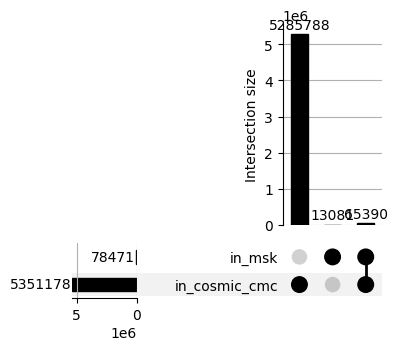

KeyError: '[(False, False, True, False, False, False, False, False, False), (False, False, False, True, False, False, False, False, False), (False, False, False, False, True, False, False, False, False), (False, False, False, False, False, True, False, False, False), (False, False, False, False, False, False, True, False, False), (False, False, False, False, False, False, False, True, False), (False, False, False, False, False, False, False, False, True)] not in index'

In [35]:
# columns = ['in_cosmic_cmc', 'in_msk']
columns = ['in_cosmic_cmc', 'in_cosmic_mutation_census', 'in_cosmic_genome_screen', 'in_cosmic_targeted_screen', 'in_cosmic_resistance', 'in_gdc', 'in_msk', 'in_tcga']
counts = combined_df.groupby(['in_cosmic_cmc', 'in_msk']).size()

# Upset plot with correct individual set sizes
upset = UpSet(counts, show_counts=True)
upset.plot()
plt.show()

# Create the tuples
tuples_list = []
for i in range(len(columns)):
    # Create a list of False values
    tuple_values = [False] * len(columns)
    # Set the i-th position to True
    tuple_values[i] = True
    # Convert to tuple and append to the list
    tuples_list.append(tuple(tuple_values))

# Append a tuple of all True values
tuples_list.append(tuple([True] * len(columns)))

# Upset plot with correct filtered intersections
counts_filtered = counts.loc[tuples_list]
upset = UpSet(counts_filtered, show_counts=True)
upset.plot()
plt.show()

print(counts_filtered)

In [ ]:
combined_df.to_csv('/home/jrich/Desktop/CART_prostate_sc/data/reference/combined/combined_mutations_cmc_only.csv', index=False)

## uncomment after outer join works
# combined_df.to_csv('/home/jrich/Desktop/CART_prostate_sc/data/reference/combined/combined_mutations.csv', index=False)

# combined_df_cmc_only = combined_df[combined_df['in_cosmic_cmc'] == True]

# combined_df_cmc_only.to_csv('/home/jrich/Desktop/CART_prostate_sc/data/reference/combined/combined_mutations_cmc_only.csv', index=False)

In [2]:
def cosmic_cancer_make_gget_compatible(df, file_path, cmc = True):
    if cmc:
    
        df["MUTATION_URL"] = df["MUTATION_URL"].str.extract(r"id=(\d+)")
        df = df.rename(
            columns={
                "ACCESSION_NUMBER": "seq_ID",
                "Mutation CDS": "mutation",
                "MUTATION_URL": "MUTATION_ID",
            }
        )

    else:
        df = df.rename(
        columns={
            "GENE_SYMBOL": "GENE_NAME",
            "TRANSCRIPT_ACCESSION": "seq_ID",
            "MUTATION_CDS": "mutation",
        }
    )

    df["seq_ID"] = df["seq_ID"].str.split(".").str[0]
    df["GENE_NAME"] = df["GENE_NAME"].astype(str)
    df["GENOMIC_MUTATION_ID"] = df["GENOMIC_MUTATION_ID"].fillna("NA")
    df["GENOMIC_MUTATION_ID"] = df["GENOMIC_MUTATION_ID"].astype(str)
    df["MUTATION_ID"] = df["MUTATION_ID"].astype(str)

    df["mut_ID"] = (
        df["GENE_NAME"]
        + "_"
        + df["GENOMIC_MUTATION_ID"]
        + "_"
        + df["MUTATION_ID"]
    )

    df = df.drop(columns=["GENE_NAME", "GENOMIC_MUTATION_ID", "MUTATION_ID"])
    df = df.loc[:, ["seq_ID", "mutation", "mut_ID"]]

    # output_file_path = file_path.replace(".tsv", "_gget_mutate.csv")
    output_file_path = file_path
    df.to_csv(output_file_path, index=False)

def gdc_make_gget_compatible(df, file_path):
    df = df.rename(
        columns={
            "gene_name": "GENE_NAME",
            "case_id": "seq_ID",
        }
    )

    df["seq_ID"] = "NA"  #! FIX THIS

    df["mutation"] = ""  #! FIX THIS

    df["mut_ID"] = (
        df["gene_name"]
        + "_"
        + df["ssm_id"]
    )

    df = df.loc[:, ["seq_ID", "mutation", "mut_ID"]]

    mutate_csv_out = file_path.replace(".tsv", "_gget_mutate.csv")
    df.to_csv(mutate_csv_out, index=False)

def hotspots_make_gget_compatible(df, file_path):
    df["seq_ID"] = "NA"  #! FIX THIS

    df["mutation"] = ""  #! FIX THIS
    
    df["mut_ID"] = (
        df["Hugo_Symbol"]
        + "_"
        + df["HGVSG_JR"]
    )

    df = df.loc[:, ["seq_ID", "mutation", "mut_ID"]]
    
    mutate_csv_out = file_path.replace(".tsv", "_gget_mutate.csv")
    df.to_csv(mutate_csv_out, index=False)

def msk_make_gget_compatible(df, file_path):
    df["seq_ID"] = df["Transcript_ID"]

    df["mutation"] = None

    df["mut_ID"] = (
        df["Hugo_Symbol"]
        + "_"
        + df["HGVSG_JR"]
    )

    df = df.loc[:, ["seq_ID", "mutation", "mut_ID"]]

    mutate_csv_out = file_path.replace(".tsv", "_gget_mutate.csv")
    df.to_csv(mutate_csv_out, index=False)

def tcga_make_gget_compatible(df, file_path):
    df["seq_ID"] = df["transcript_name"]

    df["mutation"] = None

    df["mut_ID"] = (
        df["HUGO_Symbol"]
        + "_"
        + df["HGVSG_JR"]
    )

    df = df.loc[:, ["seq_ID", "mutation", "mut_ID"]]

    mutate_csv_out = file_path.replace(".tsv", "_gget_mutate.csv")
    df.to_csv(mutate_csv_out, index=False)

In [4]:
import pandas as pd

# cosmic_cancer_make_gget_compatible(pd.read_csv('/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/example_grch37/CancerMutationCensus_AllData_v100_GRCh37.tsv', sep='\t'), "/home/jrich/Desktop/CART_prostate_sc/cmc_example_gget_mutate.csv", cmc = True)
# cosmic_cancer_make_gget_compatible(pd.read_csv('/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37.tsv', sep='\t'), "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC/GRCh37/CancerMutationCensus_AllData_Tsv_v100_GRCh37/CancerMutationCensus_AllData_v100_GRCh37_gget_mutate.csv", cmc = True)

/tmp/ipykernel_76170/3695136789.py:4: DtypeWarning: Columns (2,56) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmic_cancer_make_gget_compatible(pd.read_csv('/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC_old/GRCh37/CancerMutationCensus_AllData_Tsv_v99_GRCh37/CancerMutationCensus_AllData_v99_GRCh37.tsv', sep='\t'), "/home/jrich/Desktop/CART_prostate_sc/data/reference/COSMIC_old/GRCh37/CancerMutationCensus_AllData_Tsv_v99_GRCh37/CancerMutationCensus_AllData_v99_GRCh37_gget_mutate.csv", cmc = True)


In [ ]:
import os
from scripts.map_enst_to_ensg import get_valid_ensembl_gene_id_bulk, get_ensembl_gene_name_bulk
from upsetplot import UpSet

def merge_gene_database_with_top_mutated_genes(custom_order: bool = False, **gene_list_dict: list[str]) -> pd.Series:
    df, gene_set_dict = make_upset_df(**gene_list_dict)

    upset_data = df.groupby(list(gene_set_dict.keys())).size()

    if custom_order:  # takes on the same order as gene_list_dict keys
        index = pd.MultiIndex.from_tuples(upset_data.keys(), names=list(gene_set_dict.keys()))
        upset_data = pd.Series(upset_data, index=index)

        # Sort the Series such that entries containing RNAseq appear first
        upset_data = upset_data.sort_index(level=list(gene_set_dict.keys())[0], ascending=False)  # assumes experiment comes first

    return upset_data


def make_upset_df(**gene_list_dict: list[str]) -> tuple[pd.DataFrame, dict[str, set[str]]]:
    gene_set_dict = {name: set(gene_list) for name, gene_list in gene_list_dict.items()}

    all_genes = set().union(*gene_set_dict.values())

    all_genes = sorted(all_genes)

    data = {}
    for key, gene_set in gene_set_dict.items():
        data[key] = [True if gene in gene_set else False for gene in all_genes]

    data['Gene'] = all_genes

    df = pd.DataFrame(data).set_index('Gene')

    return df, gene_set_dict

def extract_first_ensg(synonyms: str) -> str:
    # Split the string by commas
    synonyms_list = synonyms.split(',')
    # Find the first entry that starts with 'ENSG'
    for synonym in synonyms_list:
        if synonym.startswith('ENSG'):
            return synonym
    return "Unknown"  # Return None if no 'ENSG' entry is found

def make_upset_plot(cosmic_gene_census_df, cosmic_hallmark_df, oncokb_df, merge_on_gene_name_type_upset = "Symbol", remove_non_ensembl_genes = False, custom_order = False, output_figure_dir = "/home/jrich/Desktop/CART_prostate_sc/upset_test_out/"):
    assert (
            cosmic_gene_census_df is not None
            and cosmic_hallmark_df is not None
            and oncokb_df is not None
    ), "Please load the cosmic_gene_census_df, cosmic_hallmark_df, and oncokb_df DataFrames first."

    if merge_on_gene_name_type_upset == "Symbol":
        cosmic_gene_census_gene_list_for_upset = cosmic_gene_census_df['GENE_SYMBOL'].tolist()
        cosmic_hallmark_gene_list_for_upset = cosmic_hallmark_df['GENE_SYMBOL'].tolist()
        oncokb_gene_list_for_upset = oncokb_df['Hugo Symbol'].tolist()

    elif merge_on_gene_name_type_upset == "Ensembl":
        cosmic_gene_census_df['Ensembl_Gene_ID'] = cosmic_gene_census_df['SYNONYMS'].apply(extract_first_ensg)
        cosmic_gene_census_df['Ensembl_Gene_ID'] = cosmic_gene_census_df['Ensembl_Gene_ID'].str.replace(r'\.\d+', '', regex=True)
        cosmic_gene_census_gene_list = cosmic_gene_census_df['Ensembl_Gene_ID'].tolist()

        cosmic_hallmark_df = pd.merge(cosmic_hallmark_df, cosmic_gene_census_df[['GENE_SYMBOL', 'COSMIC_GENE_ID', 'Ensembl_Gene_ID']], on=['GENE_SYMBOL', 'COSMIC_GENE_ID'], how='left')
        cosmic_hallmark_gene_list = cosmic_hallmark_df['Ensembl_Gene_ID'].tolist()

        oncokb_df['Ensembl_Gene_ID'] = oncokb_df.progress_apply(get_valid_ensembl_gene_id_bulk(oncokb_df), axis = 1, transcript_column = "GRCh37 Isoform", gene_column = 'Hugo Symbol')
        oncokb_gene_list = oncokb_df['Ensembl_Gene_ID'].tolist()

        if remove_non_ensembl_genes:
            cosmic_gene_census_gene_list_for_upset = [gene for gene in cosmic_gene_census_gene_list if gene.startswith('ENSG')]
            cosmic_hallmark_gene_list_for_upset = [gene for gene in cosmic_hallmark_gene_list if gene.startswith('ENSG')]
            oncokb_gene_list_for_upset = [gene for gene in oncokb_gene_list if gene.startswith('ENSG')]

        else:
            cosmic_gene_census_gene_list_for_upset = cosmic_gene_census_gene_list
            cosmic_hallmark_gene_list_for_upset = cosmic_hallmark_gene_list
            oncokb_gene_list_for_upset = oncokb_gene_list

    else:
        raise ValueError("Invalid merge_on_gene_name_type_upset. Please choose from 'Symbol', 'Ensembl'")

    gene_list_dict = {
        "Cosmic_gene_census": cosmic_gene_census_gene_list_for_upset,
        "Cosmic_hallmark_genes": cosmic_hallmark_gene_list_for_upset,
        "OncoKB_cancer_genes": oncokb_gene_list_for_upset
    }

    upset_data = merge_gene_database_with_top_mutated_genes(**gene_list_dict, custom_order=custom_order)

    sort_by = "input" if custom_order else "degree"
    upset = UpSet(upset_data, show_counts=True, sort_by = sort_by)
    upset.plot()

    plt.savefig(os.path.join(output_figure_dir, 'gene_upset_across_databases.png'))

    plt.show()

In [ ]:
make_upset_plot(cosmic_gene_census_df, cosmic_hallmark_df, oncokb_df, merge_on_gene_name_type_upset = "Symbol", remove_non_ensembl_genes = False, custom_order = False, output_figure_dir = "/home/jrich/Desktop/CART_prostate_sc/upset_test_out/")